# 스마트 시티 프로젝트: 도시 환경 모니터링 및 최적화

## 배경
당신은 대규모 스마트 시티 프로젝트의 데이터 과학자로 고용되었습니다. 이 프로젝트는 도시의 다양한 환경 요소를 모니터링하고 최적화하는 것을 목표로 합니다. 당신의 첫 번째 과제는 대기 질, 교통 흐름, 에너지 소비에 관한 데이터를 분석하는 것입니다.

## 데이터셋
- 파일명: smart_city_data.csv
- 내용: 1년간의 시간별 데이터로, 대기 질 지수, 교통량, 에너지 소비량, 기상 정보 등을 포함

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
import os
plt.rc('font', family = 'Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 데이터 로드
df = pd.read_csv('smart_city_data1.csv')
df.head()

,timestamp,temperature,humidity,wind_speed,aqi,aqi_ma24,traffic,congestion,energy_consumption,energy_mean,energy_std
0,2022-01-01 0:00,16.490142,83.081043,5.240700,108.087306,108.087306,193.992712,False,2432.855230,2868.927127,677.021729
1,2022-01-01 1:00,14.595967,50.975153,6.440914,93.982166,101.034736,300.727772,False,2508.150308,3165.802996,658.025437
2,2022-01-01 2:00,16.964586,50.222117,3.282828,92.901503,98.323658,232.585031,False,2208.624810,3573.198461,917.720707
3,2022-01-01 3:00,19.601370,74.082277,8.391032,91.374001,96.586244,276.089671,False,2968.122196,3839.320253,941.483599
4,2022-01-01 4:00,14.340580,69.694355,0.905666,91.832702,95.635536,368.476045,False,3867.308716,3983.463882,1020.648019


## 1. 데이터 전처리 및 특성 공학 (25점)

### 1.1 시간 관련 특성 생성
다음 시간 관련 특성들을 생성하세요:
a) hour_of_day: 0-23
b) day_of_week: 0(월요일)-6(일요일)
c) month: 1-12
d) season: 'spring', 'summer', 'fall', 'winter'
e) is_holiday: 공휴일이면 1, 아니면 0 (공휴일 목록은 별도로 제공됨)

In [3]:
# 여기에 코드를 작성하세요
#season은 봄 : 3~5월, 여름 : 6~8월, 가을 : 9~11월 겨울 12~2월 로 풀면 될 것 같습니다
holidays = [
    '2022-01-01', '2022-01-17', '2022-02-21', '2022-05-30', '2022-07-04', 
    '2022-09-05', '2022-11-24', '2022-12-25'
]
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['day_of_week'] = (df['timestamp'].dt.dayofweek+1)%7
df['month'] = df['timestamp'].dt.month
df['date'] = df['timestamp'].dt.strftime('%Y-%m-%d')
df['hour_of_day'] = df['timestamp'].dt.hour
df['is_holiday'] = df['date'].map(lambda x: 1 if x in [
    '2022-01-01', '2022-01-17', '2022-02-21', '2022-05-30', '2022-07-04', 
    '2022-09-05', '2022-11-24', '2022-12-25'
] else 0)
df['season'] = df['month'].apply(lambda x: 'spring' if x in [3, 4, 5]
                                 else 'summer' if x in [6, 7, 8]
                                 else 'fall' if x in [9, 10, 11]
                                 else 'winter')


### 1.2 대기 질 지수(AQI) 관련 특성 생성
대기 질 지수(AQI)를 기반으로 다음 특성을 생성하세요:
a) aqi_category: AQI < 50 'Good', 50-100 'Moderate', 100-150 'Unhealthy for Sensitive Groups', > 150 'Unhealthy'
b) aqi_trend: 이전 24시간 동안의 AQI 변화율 (%)

In [4]:
df['aqi_category'] = df['aqi'].map(lambda x: 
    'Good' if x < 50 else 
    'Moderate' if 50 <= x <= 100 else 
    'Unhealthy for Sensitive Groups' if 100 <= x <= 150 else 
    'Unhealthy'
)

df['aqi_24h_ago'] = df['aqi'].shift(24)
df['aqi_trend'] = ((df['aqi']- df['aqi_24h_ago'])/df['aqi_24h_ago']*100).round(2)
df.loc[df['aqi_trend'].isna(), 'aqi_trend'] = 0.00
df = df.drop('aqi_24h_ago', axis=1)

### 1.3 교통 데이터 관련 특성 생성
교통 데이터를 사용하여 다음 특성을 생성하세요:
a) traffic_intensity: 현재 교통량을 해당 시간대의 평균 교통량으로 나눈 비율
b) congestion_duration: 교통 체증(traffic_intensity > 1.5)이 지속된 연속 시간

In [5]:
# 여기에 코드를 작성하세요
traffic_hour_mean = df.groupby(['hour_of_day'])['traffic'].mean()
df['traffic_hour_mean'] = df['hour_of_day'].map(traffic_hour_mean)
df['traffic_intensity'] = df['traffic']/df['traffic_hour_mean']
# congestion 열 생성 (traffic_intensity > 1.5인 경우 True
df['congestion'] = (df['traffic_intensity'] > 1.5) 
#값이 전의 행과 다르면 true  그럼 이는 1로 인식 값이 전의 행과  같은면 flase로 0으로 인식 true로 나오기 전까지는 계속 1을
#true가 나오면 1이 증가
df['congestion_group'] = (df['congestion'] != df['congestion'].shift()).cumsum() # 연속된 체증 그룹 식별
# cumcount() 함수는 각 그룹 내에서 요소가 나타나는 순서를 0부터 세기 시작
#같은 그룹에 속한 첫 번째 항목은 0, 두 번째 항목은 1, 세 번째 항목은 2로 나타냄
df['hours_in_group'] = df.groupby('congestion_group').cumcount() + 1 
# congestion이 True인 그룹에 대해서만 지속 시간 할당
df['congestion_duration'] = np.where(df['congestion'], df['hours_in_group'], 0) 

df = df.drop(['congestion_group', 'hours_in_group'], axis=1)
print(df['congestion_duration'].value_counts())

0    8465
1     273
2      18
3       2
4       1
5       1
Name: congestion_duration, dtype: int64


### 1.4 에너지 소비 데이터 관련 특성 생성
에너지 소비 데이터를 사용하여 다음 특성을 생성하세요:
a) energy_anomaly: 현재 에너지 소비량이 같은 요일, 같은 시간대의 평균보다 2표준편차 이상 높으면 1, 아니면 0
b) cumulative_energy: 해당 일자의 자정부터 현재 시간까지의 누적 에너지 소비량

In [6]:
# 여기에 코드를 작성하세요
energy_consumption_mean = df.groupby(['day_of_week','hour_of_day'])['energy_consumption'].agg(['mean','std']).reset_index()
df = df.merge(energy_consumption_mean, on=['day_of_week', 'hour_of_day'])
df['energy_anomaly'] = df.apply(lambda x: 1 if x['energy_consumption'] > (x['mean']+2*x['std']) else 0 ,axis=1)
df['cumulative_energy'] = df.groupby('date')['energy_consumption'].cumsum()

### 1.5 결측치와 이상치 처리
위에서 생성한 특성들을 포함하여 전체 데이터셋의 결측치와 이상치를 처리하세요. 처리 방법과 그 이유를 설명하세요.

In [7]:
df['traffic'] = df['traffic'].replace(0, np.nan)
df = df.sort_values('timestamp').reset_index(drop=True)
df['traffic'] = df['traffic'].interpolate(method='linear')
df['traffic'] = df['traffic'].interpolate(mothod='linear')
traffic_hour_mean = df.groupby(['hour_of_day'])['traffic'].mean()
df['traffic_hour_mean'] = df['hour_of_day'].map(traffic_hour_mean)
df['traffic_intensity'] = df['traffic']/df['traffic_hour_mean']
pd.DataFrame(df.isna().sum()).T

,timestamp,temperature,humidity,wind_speed,aqi,aqi_ma24,traffic,congestion,energy_consumption,energy_mean,...,season,aqi_category,aqi_trend,traffic_hour_mean,traffic_intensity,congestion_duration,mean,std,energy_anomaly,cumulative_energy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
traffic_intensity에 결측치가  365개 존재. 이유는 모든 날짜에 18시에 값들이 다 0임.
18시에 값들을 보간법으로 대체. 하고 traffic_intensity   값들을 다시 재계산 해서 결측치를 채움

In [8]:
df = df.drop(columns=['mean','std','date'])

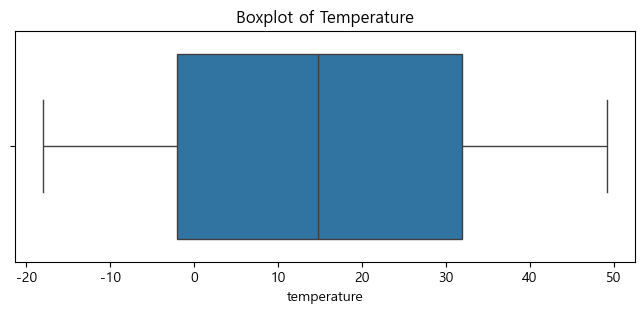

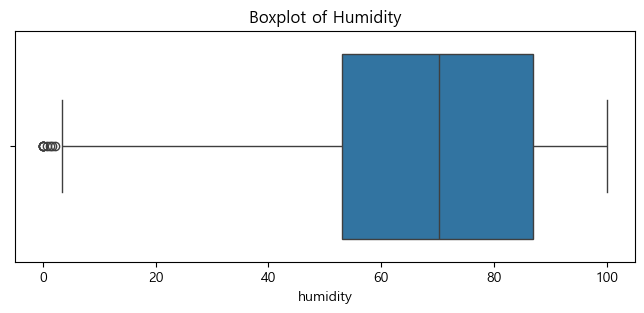

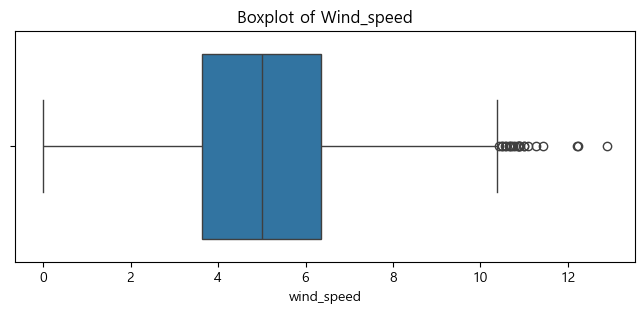

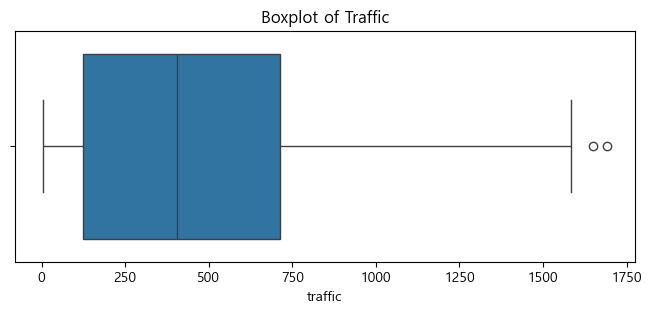

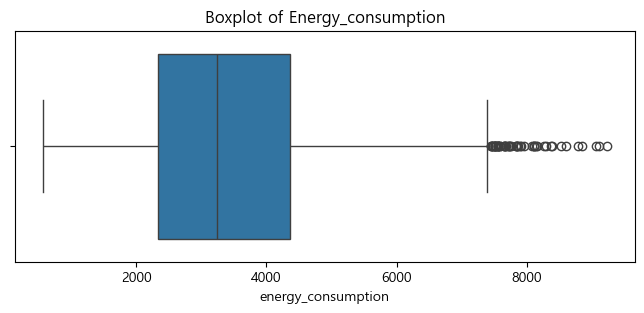

 파생변수를 제외한 독립변수들의 이상치를 확인하여 보았다.
'humidity', 'wind_speed', 'traffic', 'energy_consumption' 4개 컬럼에서 이상치가 확인되었다.



In [9]:
for col in ['temperature', 'humidity', 'wind_speed', 'traffic', 'energy_consumption']:
    plt.figure(figsize=(8, 3))  # 각 박스플롯의 크기 설정
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col.capitalize()}')
    plt.show()
print(''' 파생변수를 제외한 독립변수들의 이상치를 확인하여 보았다.
'humidity', 'wind_speed', 'traffic', 'energy_consumption' 4개 컬럼에서 이상치가 확인되었다.
''')

In [10]:
df = df.sort_values('timestamp').reset_index(drop=True)
df.head(5)

,timestamp,temperature,humidity,wind_speed,aqi,aqi_ma24,traffic,congestion,energy_consumption,energy_mean,...,hour_of_day,is_holiday,season,aqi_category,aqi_trend,traffic_hour_mean,traffic_intensity,congestion_duration,energy_anomaly,cumulative_energy
0,2022-01-01 00:00:00,16.490142,83.081043,5.240700,108.087306,108.087306,193.992712,False,2432.855230,2868.927127,...,0,1,winter,Unhealthy for Sensitive Groups,0.0,443.520280,0.437393,0,0,2432.855230
1,2022-01-01 01:00:00,14.595967,50.975153,6.440914,93.982166,101.034736,300.727772,False,2508.150308,3165.802996,...,1,1,winter,Moderate,0.0,562.598906,0.534533,0,0,4941.005538
2,2022-01-01 02:00:00,16.964586,50.222117,3.282828,92.901503,98.323658,232.585031,False,2208.624810,3573.198461,...,2,1,winter,Moderate,0.0,669.496838,0.347403,0,0,7149.630348
3,2022-01-01 03:00:00,19.601370,74.082277,8.391032,91.374001,96.586244,276.089671,False,2968.122196,3839.320253,...,3,1,winter,Moderate,0.0,761.098490,0.362752,0,0,10117.752544
4,2022-01-01 04:00:00,14.340580,69.694355,0.905666,91.832702,95.635536,368.476045,False,3867.308716,3983.463882,...,4,1,winter,Moderate,0.0,843.339313,0.436925,0,0,13985.061260


In [11]:
# 이상치 감지 및 선형 보간법으로 대체
def replace_outliers_with_interpolation(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lb = Q1 - 1.5 * IQR
    ub = Q3 + 1.5 * IQR
    
    # 이상치 탐지
    outliers = (data < lb) | (data > ub)
    
    # 이상치를 NaN으로 대체한 후 선형 보간법 적용
    data[outliers] = np.nan
    data = data.interpolate(method='linear').ffill().bfill()
    
    return data

# 데이터프레임의 각 열에 대해 이상치 대체 적용
for col in ['temperature', 'humidity', 'wind_speed', 'traffic', 'energy_consumption']:
    df[col] = replace_outliers_with_interpolation(df[col])

# 결과 확인
print(df.head())



            timestamp  temperature   humidity  wind_speed         aqi  \
0 2022-01-01 00:00:00    16.490142  83.081043    5.240700  108.087306   
1 2022-01-01 01:00:00    14.595967  50.975153    6.440914   93.982166   
2 2022-01-01 02:00:00    16.964586  50.222117    3.282828   92.901503   
3 2022-01-01 03:00:00    19.601370  74.082277    8.391032   91.374001   
4 2022-01-01 04:00:00    14.340580  69.694355    0.905666   91.832702   

     aqi_ma24     traffic  congestion  energy_consumption  energy_mean  ...  \
0  108.087306  193.992712       False         2432.855230  2868.927127  ...   
1  101.034736  300.727772       False         2508.150308  3165.802996  ...   
2   98.323658  232.585031       False         2208.624810  3573.198461  ...   
3   96.586244  276.089671       False         2968.122196  3839.320253  ...   
4   95.635536  368.476045       False         3867.308716  3983.463882  ...   

   hour_of_day  is_holiday  season                    aqi_category  aqi_trend  \
0    

C:\Users\user\AppData\Local\Temp\ipykernel_18828\1258234170.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[outliers] = np.nan


## 2. 탐색적 데이터 분석 (EDA) (20점)

### 2.1 변수 간 상관관계 분석
대기 질, 교통 흐름, 에너지 소비 간의 상관관계를 분석하세요. 최소 3개의 다른 시각화 기법을 사용하여 결과를 표현하세요.

                         aqi   traffic  energy_consumption
aqi                 1.000000  0.064716            0.186890
traffic             0.064716  1.000000            0.789417
energy_consumption  0.186890  0.789417            1.000000
energy_consumption과 traffic 사이에 높은 양의 상관관계가 있음을 볼수 있다


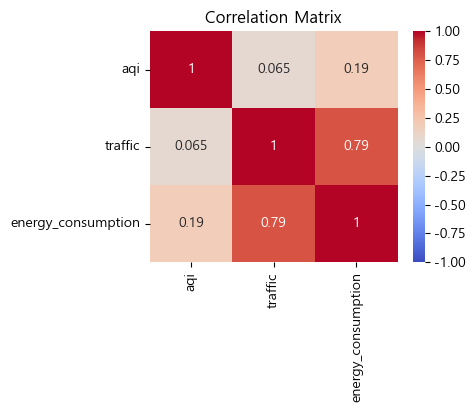

In [12]:
# 여기에 코드를 작성하세요
temp  = df[['timestamp','aqi','traffic','energy_consumption']]
temp.set_index('timestamp', inplace=True)
corr = temp.corr()
print(corr)
print('''energy_consumption과 traffic 사이에 높은 양의 상관관계가 있음을 볼수 있다''')

# 히트맵 시각화
plt.figure(figsize=(4, 3))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


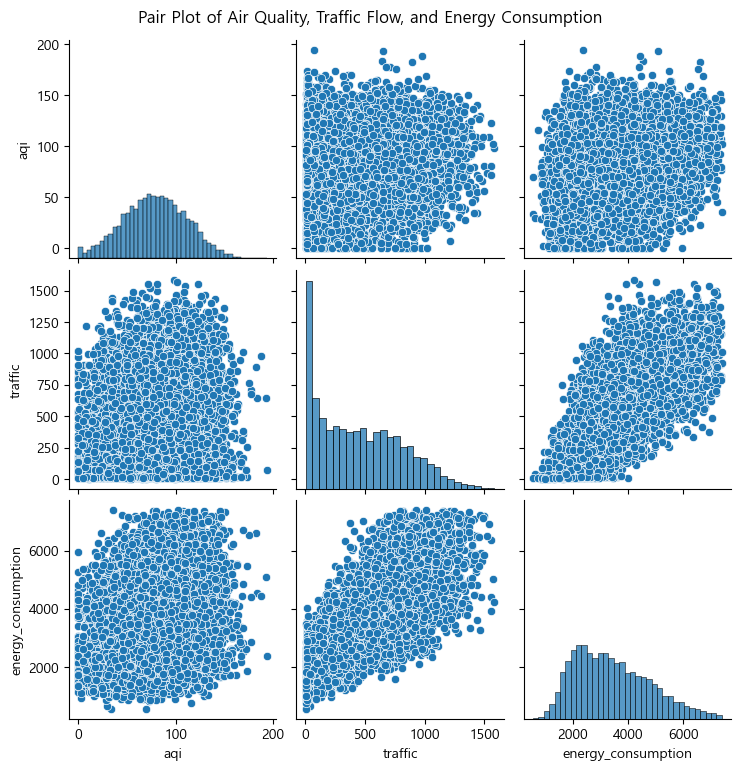

In [13]:
# 산점도 행렬 시각화
sns.pairplot(temp)
plt.suptitle('Pair Plot of Air Quality, Traffic Flow, and Energy Consumption', y=1.02)
plt.show()

In [14]:
df.set_index('timestamp', inplace=True)

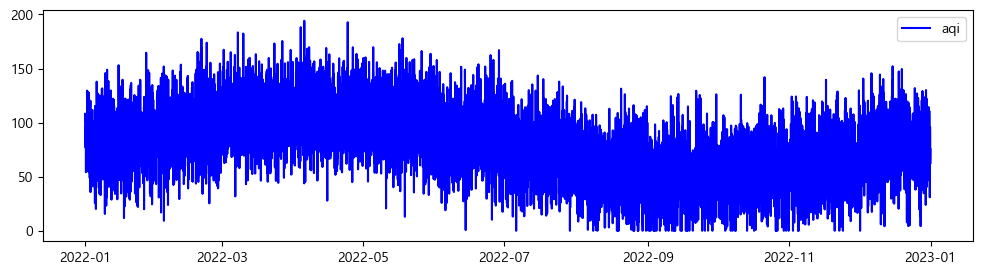

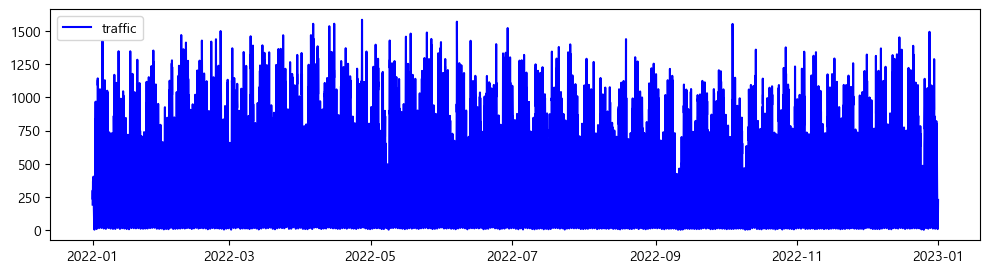

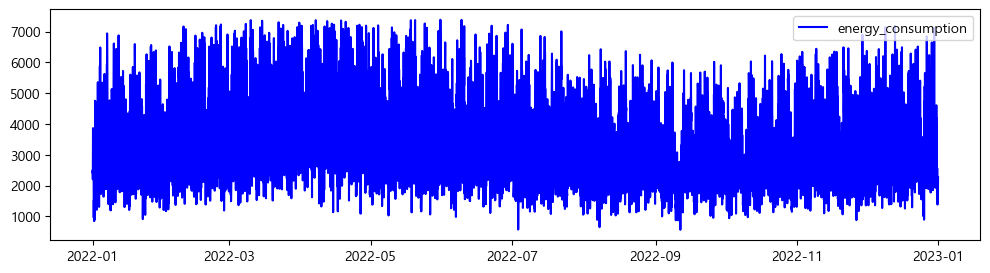

In [15]:
# 시간에 따른 세 변수의 변화를 비교

for col in ['aqi','traffic','energy_consumption']:
    plt.figure(figsize=(12, 3))
    plt.plot(df.index, df[col], label=f'{col}', color='blue')
    plt.legend()
    plt.show()


### 2.2 시간적 패턴 분석
계절별, 요일별 패턴을 분석하세요. 각 주요 변수(AQI, 교통량, 에너지 소비)에 대해 히트맵을 생성하여 시간적 패턴을 시각화하세요.

C:\Users\user\AppData\Local\Temp\ipykernel_18828\3119976065.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = df.groupby(['season','day_of_week'])['aqi','traffic','energy_consumption'].mean()


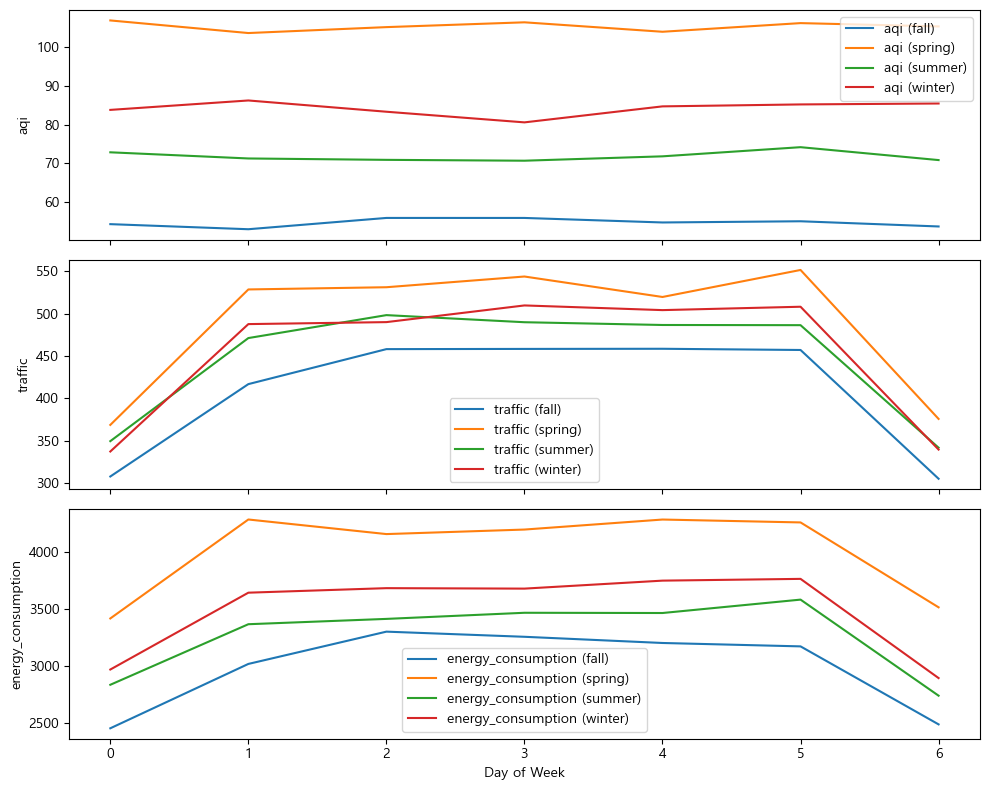

아래 그래프는 요일별로 계절별 차이를 시각화한 그래프이다
그래프를 보면 계절별 차이가 뜨렷함을 알수 있다. 봄에 aqi가 가장 높다 


In [16]:
import matplotlib.pyplot as plt

# temp는 다음과 같은 형태의 데이터프레임이라고 가정합니다.
temp = df.groupby(['season','day_of_week'])['aqi','traffic','energy_consumption'].mean()

# 인덱스를 다시 컬럼으로 복구 (MultiIndex를 일반 Index로 변환)
temp = temp.reset_index()

# 고유한 계절 값 가져오기
seasons = temp['season'].unique()
cols = ['aqi', 'traffic', 'energy_consumption']

# 서브플롯 생성
fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(10, 8), sharex=True)

# 각 계절별로 플롯 생성
for season in seasons:
    season_data = temp[temp['season'] == season]
    for i, col in enumerate(cols):
        axes[i].plot(season_data['day_of_week'], season_data[col], label=f'{col} ({season})')

        # Y축 제목과 레전드 추가
        axes[i].set_ylabel(col)
        axes[i].legend()

# 전체 플롯에 X축 라벨 추가
plt.xlabel('Day of Week')

# 그래프 간 간격 조정
plt.tight_layout()

# 그래프 출력
plt.show()

print('''아래 그래프는 요일별로 계절별 차이를 시각화한 그래프이다
그래프를 보면 계절별 차이가 뜨렷함을 알수 있다. 봄에 aqi가 가장 높다 ''')

C:\Users\user\AppData\Local\Temp\ipykernel_18828\3635307119.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = df.groupby(['hour_of_day','day_of_week'])['aqi', 'traffic', 'energy_consumption'].mean().unstack()


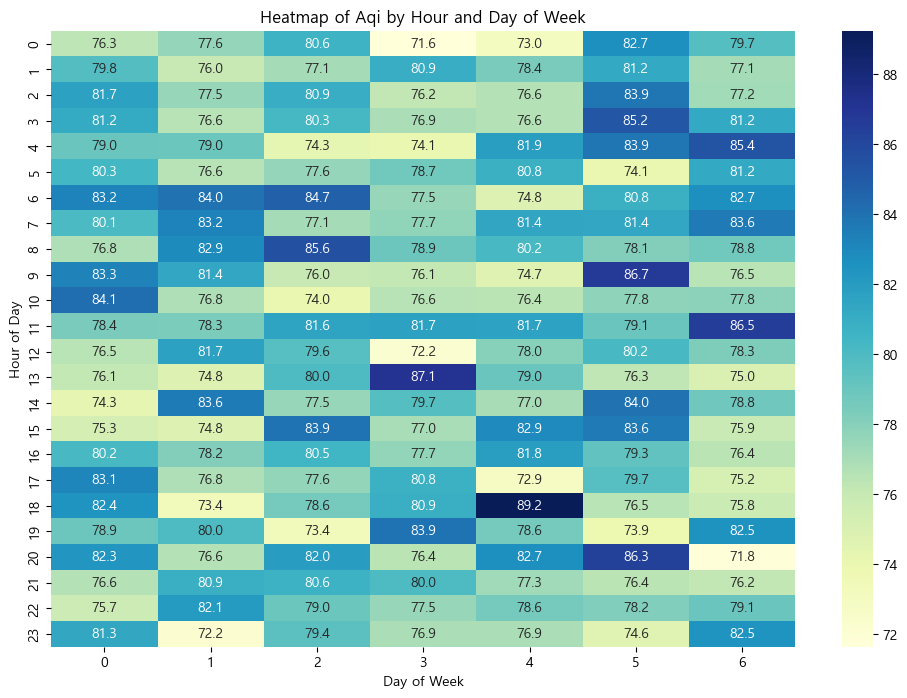

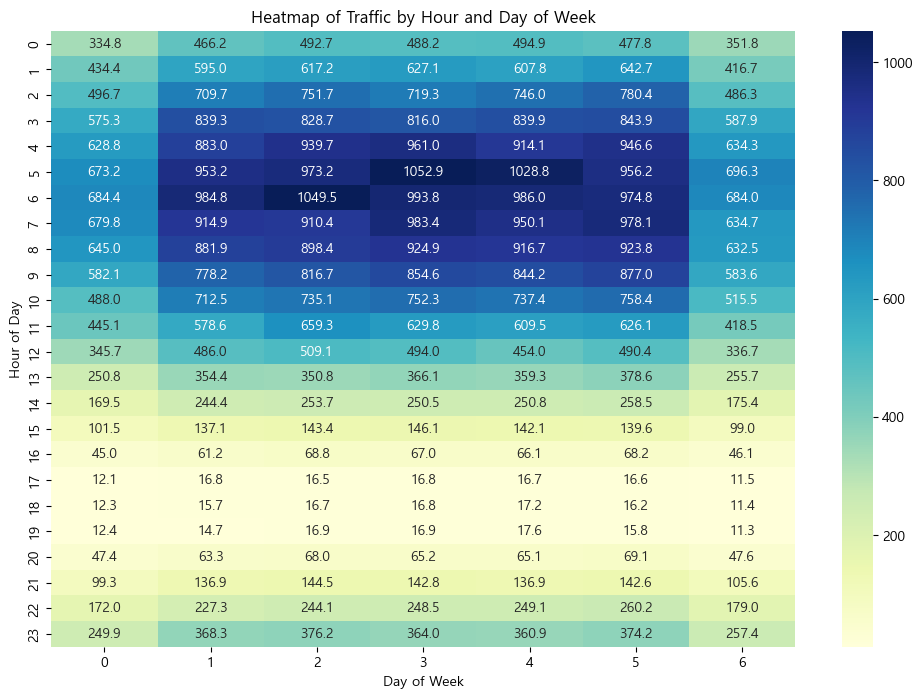

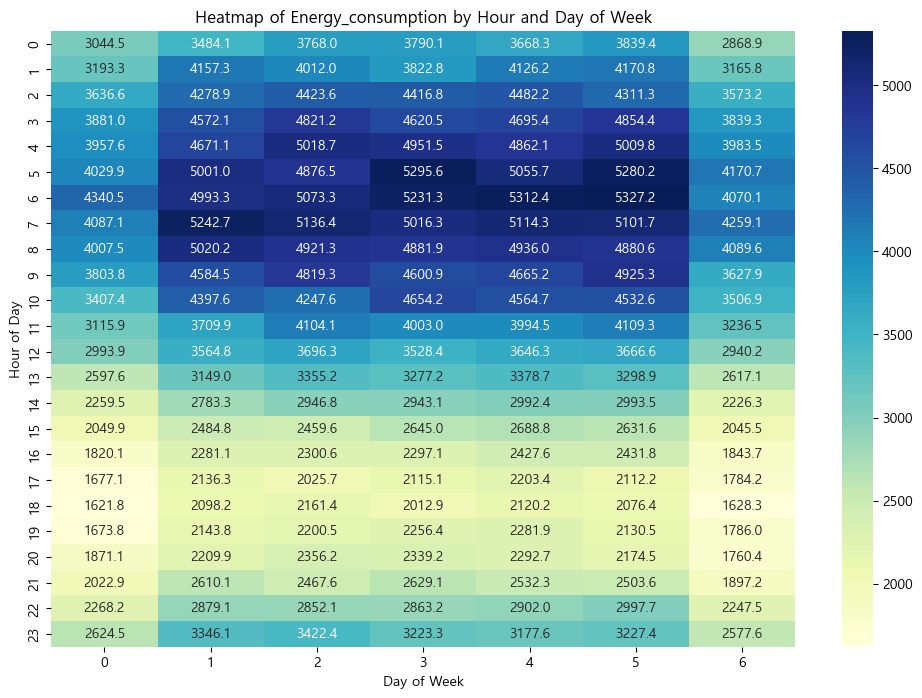

In [17]:
temp = df.groupby(['hour_of_day','day_of_week'])['aqi', 'traffic', 'energy_consumption'].mean().unstack()
# 임의로 2차원 데이터를 생성하기 위해 day_of_week로 그룹화
for col in ['aqi', 'traffic', 'energy_consumption']:
    plt.figure(figsize=(12, 8))
    sns.heatmap(temp[col], cmap='YlGnBu', annot=True, fmt=".1f")
    plt.title(f'Heatmap of {col.capitalize()} by Hour and Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Hour of Day')
    plt.show()

1. 주말로 갈수록 대기질의 숫자가 낮아지고 평일에는 6에서 8사이에
18시에서 22사이에 요일별로 다른시간대에 aqi가 높게 나타난다. 출근시간대에는
시간이 비슷하게 높게나타나나 저녁시간대에는 시간이 분산해서 aqi 나타남을 볼수 있다

2. traffic은 주로 새벽 오전시간대에 높게 나타난다

3. 에너지 소비도 평일, 오전 시간대에 높이 나타남을 알수 잇다

### 2.3 공휴일 영향 분석
공휴일이 대기 질, 교통 흐름, 에너지 소비에 미치는 영향을 분석하세요. 통계적 검정을 사용하여 차이의 유의성을 확인하세요.

In [18]:
from scipy.stats import ttest_ind

# 공휴일과 비공휴일로 데이터를 분리
holiday_data = df[df['is_holiday'] == True]
non_holiday_data = df[df['is_holiday'] == False]

# 각 변수에 대해 t-검정 수행
for col in ['aqi', 'traffic', 'energy_consumption']:
    t_stat, p_value = ttest_ind(holiday_data[col], non_holiday_data[col], equal_var=False)
    print(f'{col.capitalize()} - t-statistic: {t_stat:.4f}, p-value: {p_value:.4f}')
print('''
공기질과 교통량에서는 유의한 차이가 없다
에너지 소비량에서 pvalue가 0.05 보자 작게 나옮으로 유의한 차이가 있음을 알수 있다''')

Aqi - t-statistic: 0.2317, p-value: 0.8170
Traffic - t-statistic: -1.5006, p-value: 0.1350
Energy_consumption - t-statistic: -3.1605, p-value: 0.0018

공기질과 교통량에서는 유의한 차이가 없다
에너지 소비량에서 pvalue가 0.05 보자 작게 나옮으로 유의한 차이가 있음을 알수 있다


### 2.4 기상 조건과 주요 변수 관계 분석
기상 조건(기온, 습도, 풍속 등)과 주요 변수들 간의 관계를 분석하세요. 비선형적 관계도 고려하여 적절한 시각화 방법을 선택하세요.

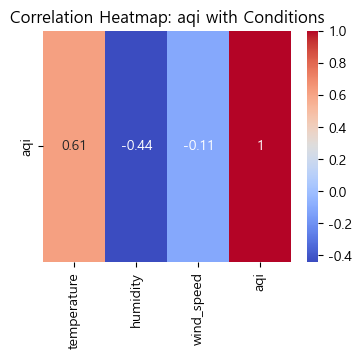

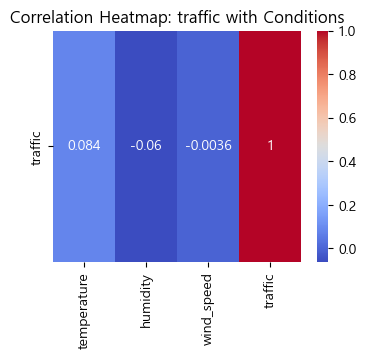

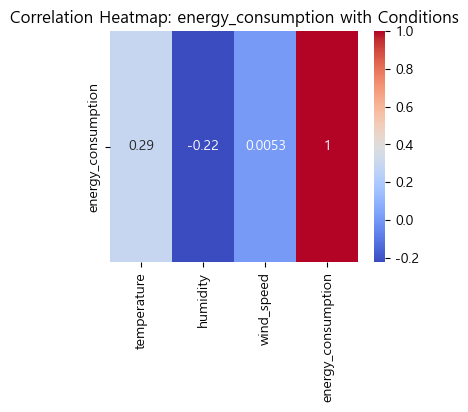

In [19]:
# 여기에 코드를 작성하세요
condition =df[['temperature', 'humidity', 'wind_speed']]
columns = df[[ 'aqi','traffic','energy_consumption']]

for col in columns:
    # 조건과 열 결합
    temp = pd.concat([condition, df[[col]]], axis=1)
    temp1 = temp.corr().loc[[col], :]
    # 히트맵 시각화
    plt.figure(figsize=(4, 3))
    sns.heatmap(temp1, annot=True, cmap='coolwarm')
    plt.title(f'Correlation Heatmap: {col} with Conditions')
    plt.show()

## 3. 예측 모델링 (35점)

### 3.1 AQI 예측 모델 개발
다음 24시간 동안의 시간별 AQI를 예측하는 모델을 개발하세요. 다음 두 가지 접근 방식을 비교하세요:
a) 전통적인 시계열 모델 (예: ARIMA, Prophet)
b) 머신러닝 모델 (예: Random Forest, LSTM)
각 모델의 성능을 평가하고, 장단점을 논의하세요.

In [20]:
df['season'] = df['season'].astype('category').cat.codes
df['aqi_category'] = df['aqi_category'].astype('category').cat.codes

In [21]:
from pmdarima import auto_arima

auto_arima(df['aqi'], start_p=1, start_q=1, max_p=5,max_q=5, start_P=0, start_Q=0, max_P=5, max_Q=5,m=7, seasonal=True,
          trace=False, error_action='warn',suppress_warnings=True)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 7),
      suppress_warnings=True, with_intercept=False)

In [22]:
# 여기에 코드를 작성하세요
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

train, test = df.iloc[:-24]['aqi'], df.iloc[-24:]['aqi']


model = ARIMA(train, order = (0,1,1))
fitted = model.fit()
resid = fitted.resid
pred1 = fitted.forecast(24)

print( fitted.summary())

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    aqi   No. Observations:                 8736
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -40781.009
Date:                Mon, 19 Aug 2024   AIC                          81566.018
Time:                        21:21:37   BIC                          81580.168
Sample:                    01-01-2022   HQIC                         81570.840
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9867      0.002   -569.900      0.000      -0.990      -0.983
sigma2       664.5325     10.425     63.742      0.000     644.099     684.966
Ljung-Box (L1) (Q):                   0.08   Jarque-

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test, pred1)
mae = mean_absolute_error(test, pred1)
print(f'MSE: {mse}')
print(f'MAE: {mae}')

MSE: 391.71092829868013
MAE: 15.643643514583331


In [27]:
df1 = df

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

train, test = df1[:-24], df1[-24:]

trainx = train.drop(columns = 'aqi')
trainy = train['aqi']

testx = test.drop(columns = 'aqi')
testy = test['aqi']


# 무한대 값을 NaN으로 대체
trainx.replace([np.inf, -np.inf], np.nan, inplace=True)
testx.replace([np.inf, -np.inf], np.nan, inplace=True)

# 결측값(NaN)을 평균값으로 대체
imputer = SimpleImputer(strategy='mean')
trainx_imputed = imputer.fit_transform(trainx)
testx_imputed = imputer.transform(testx)

# RobustScaler 적용
scaler = RobustScaler()
scaled_trainx = scaler.fit_transform(trainx_imputed)
scaled_testx = scaler.transform(testx_imputed)


dt = DecisionTreeRegressor()
dt.fit(scaled_trainx, trainy)
dt_pred = dt.predict(scaled_testx)
mse = mean_squared_error(testy, dt_pred)
mae = mean_absolute_error(testy, dt_pred)
print(f'DT_MSE: {mse}')
print(f'DT_MAE: {mae}')

rf = RandomForestRegressor()
rf.fit(scaled_trainx, trainy)
rf_pred = rf.predict(scaled_testx)

mse = mean_squared_error(testy, rf_pred)
mae = mean_absolute_error(testy, rf_pred)
print(f'RF_MSE: {mse}')
print(f'RF_MAE: {mae}')

DT_MSE: 373.0900892292152
DT_MAE: 15.46536075333333
RF_MSE: 111.38660779969685
RF_MAE: 8.782420842070835


In [101]:
print(''' 결과를 보면 랜덤포레스트의 성능이 아주 우수함을볼수 있다''')

 결과를 보면 랜덤포레스트의 성능이 아주 우수함을볼수 있다


### 3.2 교통 체증 예측 모델 개발
교통 체증(traffic_intensity > 1.5)이 발생할 확률을 예측하는 분류 모델을 개발하세요. 다음 세 가지 모델을 비교하세요:
a) 로지스틱 회귀
b) Random Forest
c) Gradient Boosting (예: XGBoost, LightGBM)
ROC 커브와 precision-recall 커브를 사용하여 모델들을 평가하고 비교하세요.

In [29]:
# 여기에 코드를 작성하세요
df['traffic_intensity_clf'] =df['traffic_intensity'].map(lambda x: 1 if x > 1.5 else 0)

In [32]:
df1 = df.drop(columns = ['traffic', 'traffic_intensity','traffic_hour_mean'])
df1.columns

Index(['temperature', 'humidity', 'wind_speed', 'aqi', 'aqi_ma24',
       'congestion', 'energy_consumption', 'energy_mean', 'energy_std',
       'day_of_week', 'month', 'hour_of_day', 'is_holiday', 'season',
       'aqi_category', 'aqi_trend', 'congestion_duration', 'energy_anomaly',
       'cumulative_energy', 'traffic_intensity_clf'],
      dtype='object')

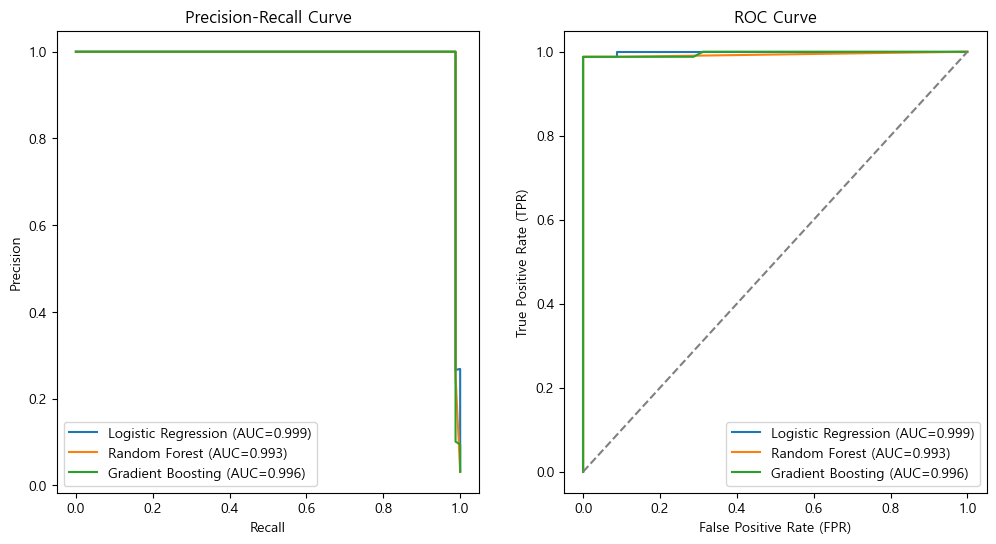

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, roc_curve,roc_auc_score
from matplotlib import pyplot as plt

X = df1.drop(columns = 'traffic_intensity_clf')
Y = df1['traffic_intensity_clf']

X.replace([np.inf, -np.inf], np.nan, inplace=True)

# 결측값(NaN)을 평균값으로 대체
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)


# RobustScaler 적용
scaler = RobustScaler()
scaled_X= scaler.fit_transform(X_imputed)



xtrain, xtest, ytrain, ytest = train_test_split(scaled_X, Y, test_size=0.3, random_state=0)

# 세 모델 초기화
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# 플롯 준비
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# 각 모델에 대해 학습 및 평가 수행
for model_name, model in models.items():
    model.fit(xtrain, ytrain)
    prob = model.predict_proba(xtest)[:, 1]

    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(ytest, prob)
    fpr, tpr, roc_thresholds = roc_curve(ytest, prob)
    auc = roc_auc_score(ytest, prob)

    # Precision-Recall Curve Plot
    ax[0].plot(recall, precision, label=f'{model_name} (AUC={auc:.3f})')

    # ROC Curve Plot
    ax[1].plot(fpr, tpr, label=f'{model_name} (AUC={auc:.3f})')

# Precision-Recall Curve 설정
ax[0].set_title('Precision-Recall Curve')
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].legend()

# ROC Curve 설정
ax[1].set_title('ROC Curve')
ax[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
ax[1].set_xlabel('False Positive Rate (FPR)')
ax[1].set_ylabel('True Positive Rate (TPR)')
ax[1].legend()

plt.show()

두그래프에서 Gradient Boosting이 AUC값이 두그래프 모두 높은 값이 나타난다.
Gradient Boosting의 성능이 가장 좋다고 할수 있다.

### 3.3 에너지 소비량 예측 모델 개발
일일 총 에너지 소비량을 예측하는 회귀 모델을 개발하세요. 다음 작업을 수행하세요:
a) 특성 중요도를 평가하고, 상위 10개 특성을 시각화하세요.
b) 교차 검증을 사용하여 모델의 안정성을 평가하세요.
c) 예측 구간을 제공하는 방법을 구현하고 설명하세요(예: 분위 회귀, 부트스트래핑 등).

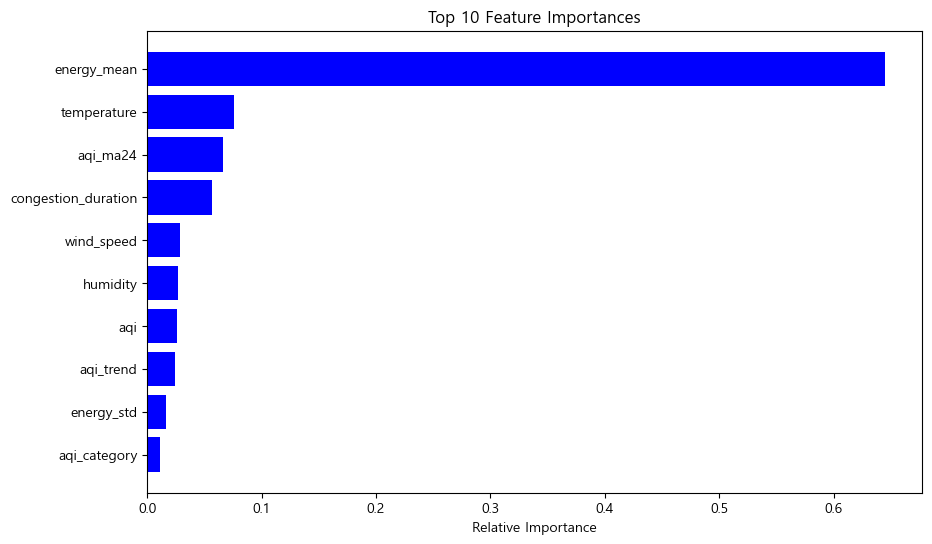

In [110]:
# 여기에 코드를 작성하세요
X = df1.drop(columns = 'energy_consumption')
Y = df1['energy_consumption']

X.replace([np.inf, -np.inf], np.nan, inplace=True)

# 결측값(NaN)을 평균값으로 대체
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)


# RobustScaler 적용
scaler = RobustScaler()
scaled_X= scaler.fit_transform(X_imputed)


xtrain, xtest, ytrain, ytest = train_test_split(scaledx, Y, test_size=0.3, random_state=0)


# 모델 초기화 및 학습
model = RandomForestRegressor(random_state=0)
model.fit(xtrain, ytrain)

# 특성 중요도 추출
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]  # 상위 10개 특성 선택

# 상위 10개 특성 시각화
plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [111]:
from sklearn.model_selection import cross_val_score

# 교차 검증을 통한 R^2 스코어 계산
cv_scores = cross_val_score(model, scaledx, Y, cv=5, scoring='r2')

print(f"Cross-validated R^2 scores: {cv_scores}")
print(f"Mean R^2 score: {np.mean(cv_scores):.3f}")

Cross-validated R^2 scores: [0.75543164 0.76852866 0.71147049 0.70049122 0.72338773]
Mean R^2 score: 0.732


## 4. 인사이트 및 권장 사항 (20점)

### 4.1 도시 환경 개선을 위한 권장 사항
위의 분석을 바탕으로, 도시 환경을 개선하기 위한 5가지 실행 가능한 권장 사항을 제시하세요. 각 권장 사항에 대해 데이터 기반 근거를 제공하세요.

[여기에 답변을 작성하세요]

### 4.2 분석의 한계점 및 개선 방안
이 분석의 한계점과 향후 개선을 위한 추가 데이터 수집 방안을 논의하세요.

[여기에 답변을 작성하세요]

# 소매업 체인점 분석 프로젝트: 매출 최적화 및 고객 행동 이해
## 배경:
```당신은 "GlobalMart"라는 대형 소매업 체인의 데이터 사이언스 팀에 새롭게 합류했습니다. 
GlobalMart는 전 세계적으로 1,000개 이상의 매장을 운영하고 있으며, 온라인 판매 채널도 보유하고 있습니다. 
최근 경영진은 데이터 기반 의사결정의 중요성을 인식하고, 매출 증대와 고객 경험 개선을 위한 프로젝트를 시작하기로 결정했습니다.
```

## 데이터셋:
파일명: globalmart_data.csv
기간: 2018년 1월 1일부터 2022년 12월 31일까지의 일일 데이터
포함 정보: 매장 정보, 제품 정보, 판매 데이터, 고객 데이터, 프로모션 정보 등

문제:



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드
df = pd.read_csv('./dataset/globalmart_data.csv')
df.head()

,date,store_id,store_size,store_location,customer_id,product_id,quantity,product_category,base_price,season_factor,location_factor,promotion,discount,price,total_price
0,2020-05-03,S0033,Medium,Suburban,C000010,P0017,1,Electronics,256.558394,1.169050,1.0,True,0.144013,219.610542,256.74
1,2022-08-14,S0026,Small,Suburban,C000914,P0083,3,Electronics,336.117410,0.863845,1.0,False,0.000000,336.117410,871.06
2,2020-08-19,S0048,Small,Rural,C000303,P0088,3,Clothing,385.434237,0.849467,0.8,True,0.227611,297.705103,606.94
3,2022-07-21,S0001,Large,Suburban,C000322,P0020,4,Food & Beverage,166.349658,0.934118,1.0,False,0.000000,166.349658,621.56
4,2018-06-04,S0049,Medium,Urban,C000817,P0076,3,Electronics,296.986070,1.091181,1.2,True,0.187564,241.282276,947.82



## 5. 데이터 전처리 및 탐색적 데이터 분석 (EDA) (30점)

### 5-1. 데이터의 품질을 검사하고, 발견된 문제점들을 나열하세요. 각 문제에 대한 적절한 처리 방법을 제안하고 실행하세요.


### 5-2. 다음 파생변수들을 생성하세요:
a) 고객 생애 가치 (Customer Lifetime Value) <br>
b) 제품별 수익률<br>
c) 매장별 일일 평균 고객 수<br>
d) 계절성 지표 (월별, 요일별)<br>


### 5-3. 매출에 영향을 미치는 주요 요인들을 시각화하여 분석하세요. 최소 5개의 다른 차트 유형을 사용하여 인사이트를 도출하세요.


### 5-4. 매장 위치, 크기, 재고 회전율 등의 요소가 매출에 미치는 영향을 분석하세요. 상관관계 분석과 적절한 통계 검정을 수행하세요.


## 6. 예측 모델링 (40점)

### 6-1. 일일 매출 예측 모델을 개발하세요. 다음 세 가지 접근 방식을 비교하세요:
a) 시계열 모델 (예: ARIMA, Prophet) <br>
b) 머신러닝 모델 (예: Random Forest, XGBoost)<br>
c) 딥러닝 모델 (예: LSTM)<br>
각 모델의 성능을 평가하고, 예측 정확도뿐만 아니라 해석 가능성과 실용성 측면에서도 비교하세요.


### 6-2. 고객 세그먼테이션을 위한 클러스터링 모델을 개발하세요. 다음 단계를 따르세요:
a) 적절한 특성을 선택하고 전처리하세요.<br>
b) 최적의 클러스터 수를 결정하기 위한 방법을 적용하세요.<br>
c) 선택한 클러스터링 알고리즘을 적용하고 결과를 시각화하세요.<br>
d) 각 클러스터의 특성을 해석하고, 비즈니스적 의미를 설명하세요.<br>


### 6-3. 장바구니 분석을 수행하여 제품 간의 연관 규칙을 찾으세요. 다음을 포함하세요:<br>
a) 지지도, 신뢰도, 향상도의 개념을 설명하고, 임계값을 설정하세요.<br>
b) 가장 강력한 연관 규칙 상위 10개를 제시하고 해석하세요.<br>
c) 발견된 규칙을 바탕으로 교차 판매 및 상향 판매 전략을 제안하세요.<br>



## 7. 최적화 및 의사결정 (20점)

### 7-1. 매장별 재고 최적화 모델을 개발하세요. 다음 요소를 고려하세요:<br>
a) 과거 판매 데이터 <br><br>
b) 제품의 유통기한<br>
c) 보관 비용<br>
d) 품절로 인한 기회 비용<br>
모델의 목적 함수와 제약 조건을 명확히 정의하고, 솔루션 접근 방식을 설명하세요.<br>



### 7-2. A/B 테스트를 설계하여 새로운 매장 레이아웃의 효과를 측정하는 계획을 수립하세요. 다음을 포함하세요:<br>
a) 귀무가설과 대립가설 설정<br>
b) 필요한 표본 크기 계산<br>
c) 실험 기간 설정<br>
d) 성공 지표 정의<br>
e) 잠재적인 편향을 최소화하기 위한 전략<br>


## 8. 비즈니스 통찰 및 제안 (10점)

### 8-1. 분석 결과를 바탕으로, GlobalMart의 매출을 증대시키고 고객 경험을 개선하기 위한 5가지 핵심 전략을 제안하세요. 각 전략에 대해 다음을 포함하세요:
a) 데이터 기반 근거<br>
b) 예상되는 비즈니스 임팩트<br>
c) 실행을 위한 단계별 계획<br>
d) 잠재적 위험과 그 완화 방안<br>



### 8-2. 이 분석 프로젝트의 한계점을 논의하고, 향후 개선을 위한 추가 데이터 수집 및 분석 방향을 제안하세요.
평가 기준:

- 데이터 처리 및 분석의 정확성과 철저함
- 사용된 방법론의 적절성과 다양성
- 결과의 해석 및 비즈니스 통찰력
- 제안된 전략의 실현 가능성과 창의성
- 전반적인 보고서의 구조와 명확성

* 참고사항:

- 모든 코드와 분석 과정을 명확히 문서화하세요.
- 사용한 가정들을 명시하고 정당화하세요.
- 결과를 비즈니스 관점에서 해석하는 것에 중점을 두세요.
- 시각화와 요약 통계를 효과적으로 활용하여 인사이트를 전달하세요.